In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import math
import random

## Image Show Modules (cv and matplotlib)

In [2]:
def cv_show(im,msg):
    cv2.imshow(msg,im)
    cv2.waitKey(0)
    cv2.destroyAllWindows()	

def plt_show(im):
    plt.axis("off")
    plt.imshow(im, cmap="gray")
    plt.show()

## Image Histogram

In [3]:
def histogram(f):
    m, n = f.shape
    h = [0.0] * 256
    for i in range(m):
        for j in range(n):
            h[f[i, j]]+=1
    return np.array(h, dtype='uint16')

In [4]:
def otsu(hist, st, en):
    prob = np.zeros_like(hist, dtype='float16')
    tot = np.sum(hist[st:en])
    prob[st:en] = hist[st:en]/tot
    coef_max = -1
    thr = -1
    for t in range(st+1, en):
        w0 = np.sum(prob[st:t]) + 0.00000001
        w1 = np.sum(prob[t:en]) + 0.00000001
        i0 = np.array([i for i in range(st, t)])
        i1 = np.array([i for i in range(t, en)])
        u0 = np.sum(i0*prob[st:t])/w0
        u1 = np.sum(i1*prob[t:en])/w1

        coef = (w0*w1)*np.power(u0-u1,2)
        if  coef > coef_max:
            coef_max = coef
            thr = t
    return thr

## ความแตกต่างระหว่าง Otsu และ Intermean

### 1. วิธีการคำนวณเกณฑ์

**Otsu Method:**
```python
# หาเกณฑ์ที่ทำให้ความแตกต่างระหว่างกลุ่มสูงสุด (Maximization)
coef = (w0*w1)*np.power(u0-u1,2)  # Inter-class variance
if coef > coef_max:  # หาค่าสูงสุด
    coef_max = coef
    thr = t
```
- ลูปผ่านทุกค่า (0-255) เพื่อหาค่าที่ทำให้ coefficient สูงสุด
- **หลักการ:** Maximize inter-class variance (เพิ่มความแตกต่างระหว่างกลุ่ม)

**Intermean Method:**
```python
# หาค่าเฉลี่ยระหว่างสองกลุ่ม แล้วทำซ้ำจนบรรจบ (Iterative)
thr = (u0 + u1) / 2  # ค่ากลางระหว่างสองกลุ่ม
while abs(t1 - t0) > 1:  # ทำซ้ำจนเปลี่ยนแปลงน้อย
    t0 = t1
```
- เริ่มจากเกณฑ์กลาง แล้วปรับเกณฑ์ซ้ำจนค่าคงที่
- **หลักการ:** Iterative convergence (ค่าบรรจบ)

---

### 2. จำนวนรอบการคำนวณ

| วิธี | การทำงาน | จำนวนรอบ |
|------|---------|---------|
| **Otsu** | ลูปผ่านทุกค่า st+1 ถึง en | ~255 ครั้ง (ทำครั้งเดียว) |
| **Intermean** | ลูปซ้ำจนค่าบรรจบ | ~3-10 ครั้ง (แต่ละรอบเร็ว) |

สรุป:

```
Otsu       → หาค่าดีที่สุด ช้ากว่า   (Best quality)
Intermean  → หาค่าดี      เร็วกว่า   (Good quality, Fast)
```

**ทั้งสองวิธีเป็น Global Thresholding แบบอัตโนมัติ** แต่ใช้หลักการคำนวณต่างกัน!

In [5]:
def plot_histogram(hist, st, en):
    plt.axis("off")
    plt.plot(hist[st:en])
    plt.show()

# ใช้วิธี Intermean แบบวนลูปในการหาค่า threshold
def otsu_loop(hist):
    st, en = 0, 256
    for inx in range(3):
        plot_histogram(hist,st,en)
        threshs = otsu(hist, st, en)
        st = threshs+1
    return threshs

## Main Process

Otsu Method คือ วิธีหาเกณฑ์ (threshold) โดยอัตโนมัติ สำหรับแปลงภาพสีเทาเป็นภาพขาวดำ

หลักการทำงาน:
Otsu Method ค้นหาค่าเกณฑ์ที่ทำให้ ความแตกต่างระหว่างสองกลุ่มพิกเซล (สว่างและเข้ม) มากที่สุด
>พิกเซล < เกณฑ์ → กลุ่มเข้ม (0 = ดำ)
>
>พิกเซล ≥ เกณฑ์ → กลุ่มสว่าง (255 = ขาว)

## ความแตกต่าง:

Global Thresholding (แบบทั่วไป) → ใช้เกณฑ์เดียวสำหรับภาพทั้งหมด
```py
# กำหนดค่าเกณฑ์เอง (Manual)
threshold = 128
out[img > threshold] = 255
```
- ใช้เกณฑ์เดียวสำหรับทั้งภาพ
- ต้องกำหนดค่าเอง (เช่น 128, 100, 150)

Otsu Method → หาเกณฑ์โดยอัตโนมัติ
```py
# คำนวณค่าเกณฑ์อัตโนมัติ
threshold = otsu(hist, 0, 256)  # เช่น ได้ 126
out[img > threshold] = 255
```
- หาเกณฑ์โดยอัตโนมัติจากฮิสโตแกรมของภาพ
- ไม่ต้องกำหนดค่าเอง
- เหมาะกับภาพที่มีการกระจายความสว่างชัดเจน
- ใช้เกณฑ์เดียวสำหรับทั้งภาพ (เหมือนกัน)
- คำนวณหาเกณฑ์ที่ดีที่สุดอัตโนมัติ (ไม่ต้องเดา)

### เปรียบเทียบวิธี Thresholding

| ประเภท | วิธีหาเกณฑ์ | ตัวอย่าง |
|--------|-----------|---------|
| **Manual Global** | กำหนดเอง | `threshold = 128` |
| **Otsu (Auto Global)** | คำนวณอัตโนมัติ | `threshold = otsu(...)` |
| **Intermean (Auto Global)** | คำนวณอัตโนมัติแบบอื่น | `threshold = intermean(...)` |
| **Adaptive/Local** | ต่างกันในแต่ละส่วนภาพ | `cv2.adaptiveThreshold()` |

**Otsu = Global Thresholding แบบอัตโนมัติ** ✓

จุดเด่นคือ **ไม่ต้องเดาค่าเกณฑ์** เพราะอัลกอริทึมจะหาให้อัตโนมัติโดยพิจารณาจากการกระจายของฮิสโตแกรม

1. Read Image

In [6]:
img = cv2.imread("./img/gray2.png", cv2.IMREAD_GRAYSCALE)
hist = histogram(img)

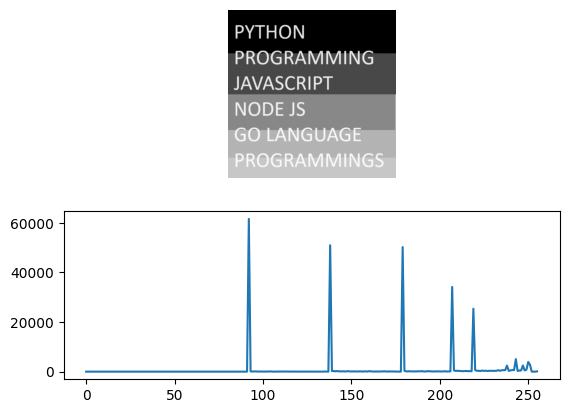

In [7]:
plt.subplot(2, 1, 1)
plt.axis("off")
plt.imshow(img, cmap="gray")

plt.subplot(2, 1, 2)
plt.plot(hist)

plt.show()

In [8]:
threshs = otsu(hist, 0, 256)
print(threshs)

161


C:\Users\Admin\AppData\Local\Temp\ipykernel_20488\1344891130.py:12: RuntimeWarning: invalid value encountered in scalar divide
  u0 = np.sum(i0*prob[st:t])/w0


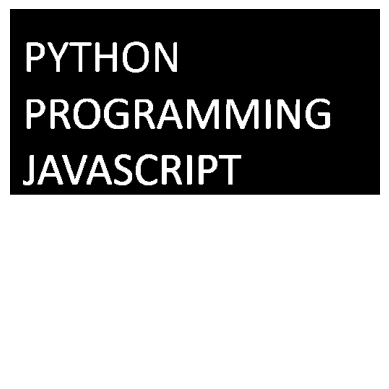

In [9]:

out = np.zeros_like(img, dtype= 'uint8')
out[img > threshs] = 255
plt_show(out)

In [10]:
def plot_histogram(hist, st, en):
    plt.axis("off")
    plt.plot(hist[st:en])
    plt.show()

def intermean_loop(hist):
    st, en = 0, 256
    for inx in range(3):
        plot_histogram(hist,st,en)
        threshs = otsu(hist, st, en)
        st = threshs+1
    return threshs
        
   

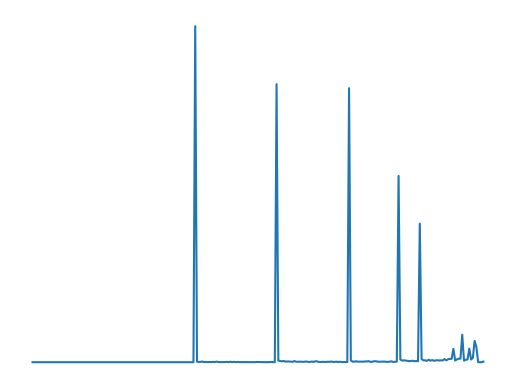

C:\Users\Admin\AppData\Local\Temp\ipykernel_20488\1344891130.py:12: RuntimeWarning: invalid value encountered in scalar divide
  u0 = np.sum(i0*prob[st:t])/w0


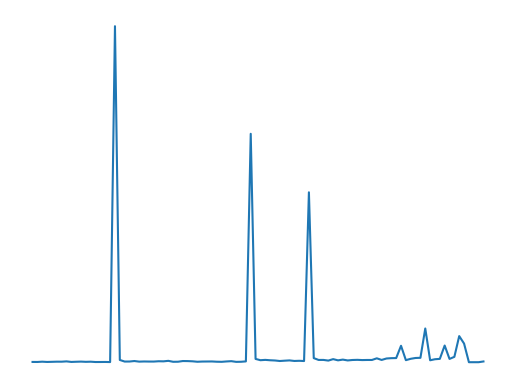

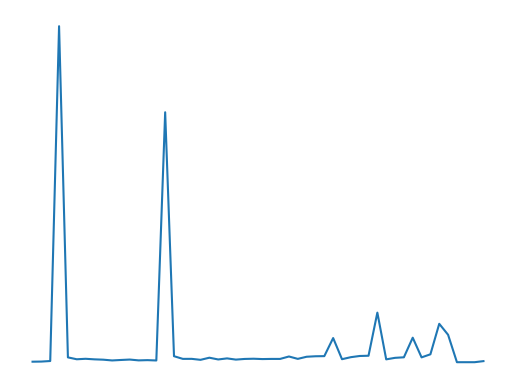

229


In [11]:
threshs = otsu_loop(hist)
print(threshs)

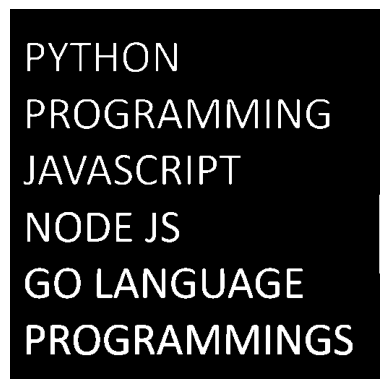

In [12]:
out = np.zeros_like(img, dtype= 'uint8')
out[img > threshs] = 255
plt_show(out)